In [1]:
%matplotlib inline
%load_ext cython

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
%%cython
import numpy as np
def pNL_THz(Eopt):
    cdef int size=Eopt.size
    cdef float[1000] pNL=np.zeros(size)
    pNL[0]=2*np.float(np.dot(Eopt,Eopt))
    for i in range(1,size):
        pNL[i]=2*np.float(np.dot(Eopt[:-i],Eopt[i:]))
    return pNL

In [3]:
""" Some  constants"""
pi = np.pi
c = 0.3
deff = 168 #pm/V
miu0 = 4*pi*1e-2 # miu0 * epsilon0 = c^2
epsilon0 = c**2/miu0 # F/mm
n_group = 2.3585
bandwidth = 2e-6 # mm
center_wavelength = 800e-6
gamma = 62*pi/180

""" Define frequency range """
OTHz = 0.1*2*pi
THzMax=50
size = 1000
num = 1000

omega0 = c*2*pi/center_wavelength
w = c*2*pi/(center_wavelength-bandwidth/2)-c*2*pi/(center_wavelength+bandwidth/2)
omega = np.linspace(omega0-THzMax/2,omega0+THzMax/2,size)
OTHz = np.linspace(0.,THzMax,size)
step = np.mean(np.diff(OTHz))

t0 = time.time()
n_THz = np.exp(np.log(1.25)/75*(OTHz))+1.32
alpha = np.exp(6e-3*OTHz)+1
delta_k = (OTHz/c)*(n_THz-n_group)
Eopt = np.exp(-4*np.log(2)*((omega-omega0)/w)**2)
pNL = pNL_THz(Eopt)

def ODE(z, E):
     return (-1j*miu0*OTHz*c/2/n_THz)*deff*epsilon0*pNL*step*np.exp(1j*delta_k*z) - 0.5*alpha*E

z0 = 0 # initial x
E0 = 0 # initial y
z1 = 1 # end point of x
vz = np.zeros(num+1)
vE = np.zeros((num+1,1000),dtype=complex)
h = (z1-z0)/num
vz[0] = z = z0
vE[0,0] = E = E0

for i in range(1,num+1):
    k1 = h*ODE(z,E)
    k2 = h*ODE(z+0.5*h, E+0.5*k1)
    k3 = h*ODE(z+0.5*h, E+0.5*k2)
    k4 = h*ODE(z+h, E+k3)
    vz[i] = z = z0 + i * h
    vE[i,:] = E = E + (k1+2*k2+2*k3+k4) / 6

print(time.time()-t0)

0.5773921012878418


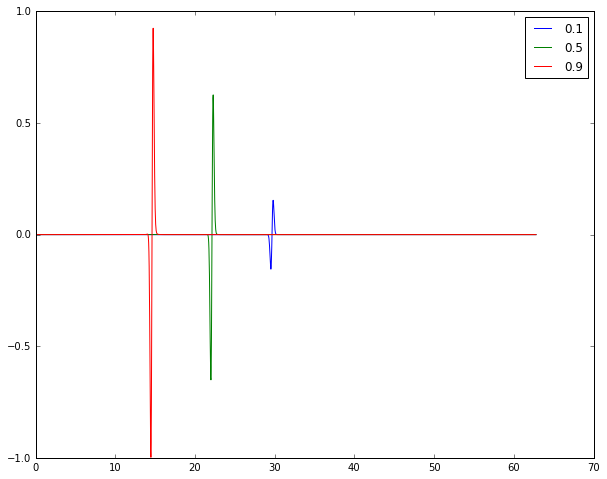

In [4]:
""" Plotting - waveform """
fig,ax=plt.subplots(figsize=(10,8))
# for i in [1,10,50,100,500,900]:
# for i in [1,5,10]:
# for i in [1]:
for i in [100, 500, 900]:
    length=len(vE[:,i])
    Ec = np.zeros(length*2-1,dtype=complex)
    loc=i
    n_THz = 5.65
    phase=np.exp(1j*vz[i]*n_THz*OTHz/c)
    
    Ec[:length-1] = (vE[loc,:])*phase
    Ec[length:] = np.flipud(np.conjugate(Ec[1:length]))
#     Ec[length:] = np.flipud(Ec[1:length])
    
#     Ec=np.conjugate(Ec)
    
    wf = np.real(np.fft.ifft((Ec)))
    #wfi = np.imag(np.fft.ifft(Ec))
    
    loc = np.amin(np.where(wf==np.amax(wf)))
    wf = np.roll(wf,loc)
    
    ax.plot(np.linspace(0,1/(2*OTHz[1]/2/pi),wf.size),np.fft.fftshift(wf),label=vz[i])
    #ax.plot(np.linspace(0,1/(2*OTHz[1]/2/pi),wf.size),np.fft.fftshift(wfi),label=loc)
#     ax.set_xlim(length-length/10,length+length/10)
    #print(np.mean(wfi))
ax.legend()
#ax.axhline(0)
#ax.set_xlim(10,20)
# ax.set_ylim(-0.1,0.1)